# Diabetes 1999-2008 Dataset

In [57]:
# Requiered Installations:
# pip install category_encoders
# pip install missingno

# Essential
import numpy as np
import pandas as pd
import re

# Visualization
import missingno as msno
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px

# preprocessing
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from category_encoders import BinaryEncoder
from sklearn.utils import resample
from imblearn.under_sampling import NearMiss

# Metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, accuracy_score,f1_score,recall_score, roc_auc_score, roc_curve, classification_report,precision_score
from sklearn.metrics import precision_recall_fscore_support
from mlxtend.evaluate import bias_variance_decomp

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

## Reading the data

**The data is splitted in 2 csv files so, we had to read both of them seperatly**

In [2]:
data = pd.read_csv("diabetic_data.csv")
IDs_ds = pd.read_csv("IDs_mapping.csv")

# First (Main) Dataset
with pd.option_context("display.max_row", 100, "display.max_columns", 100):
        display(data)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,Male,[70-80),?,1,3,7,3,MC,?,51,0,16,0,0,0,250.13,291,458,9,None,>8,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,>30
101762,443847782,74694222,AfricanAmerican,Female,[80-90),?,1,4,5,5,MC,?,33,3,18,0,0,1,560,276,787,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,NO
101763,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,MC,?,53,0,9,1,0,0,38,590,296,13,None,None,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,NO
101764,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,MC,Surgery-General,45,2,21,0,0,1,996,285,998,9,None,None,No,No,No,No,No,No,Steady,No,No,Steady,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO


In [3]:
# Second Dataset
IDs_ds.head(len(IDs_ds))

,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available
...,...,...
62,22,Transfer from hospital inpt/same fac reslt in...
63,23,Born inside this hospital
64,24,Born outside this hospital
65,25,Transfer from Ambulatory Surgery Center


## EDA on the Dataset

**In this section, we explore the data to gain more knowledge of what are we dealing with in the dataset.**

In [4]:
data.shape

(101766, 50)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

**Most of the dataset is non-numerical values and some of the attributes are number stored in a "String" form.**

In [6]:
data.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


#### Transforming the target variable to numerical and refining the nan values to be able to deal with later

In [7]:
data.readmitted = [1 if each=='<30' else 0 for each in data.readmitted]
data.replace('?', np.nan , inplace=True)

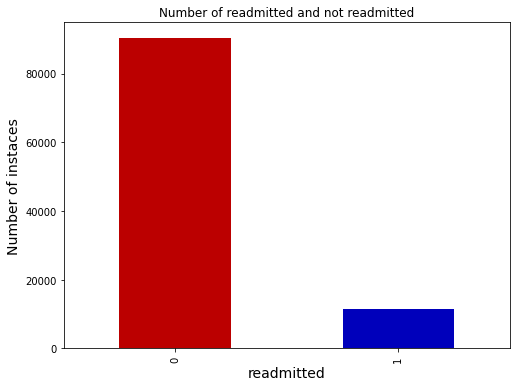

In [8]:
# Checking the balance of the dataset
ax=data['readmitted'].value_counts().plot(kind='bar',color = ['#BB0000', '#0000BB'],
                                          title='Number of readmitted and not readmitted',figsize=(8, 6))
ax.set_xlabel("readmitted",fontsize=14)
ax.set_ylabel("Number of instaces",fontsize=14)
plt.show()

**Looking at the barchart above, we can see that the dataset is heavily imbalanced with the class of not readmitted having most of the dataset.**

**Visualising the missing values in the dataset.**

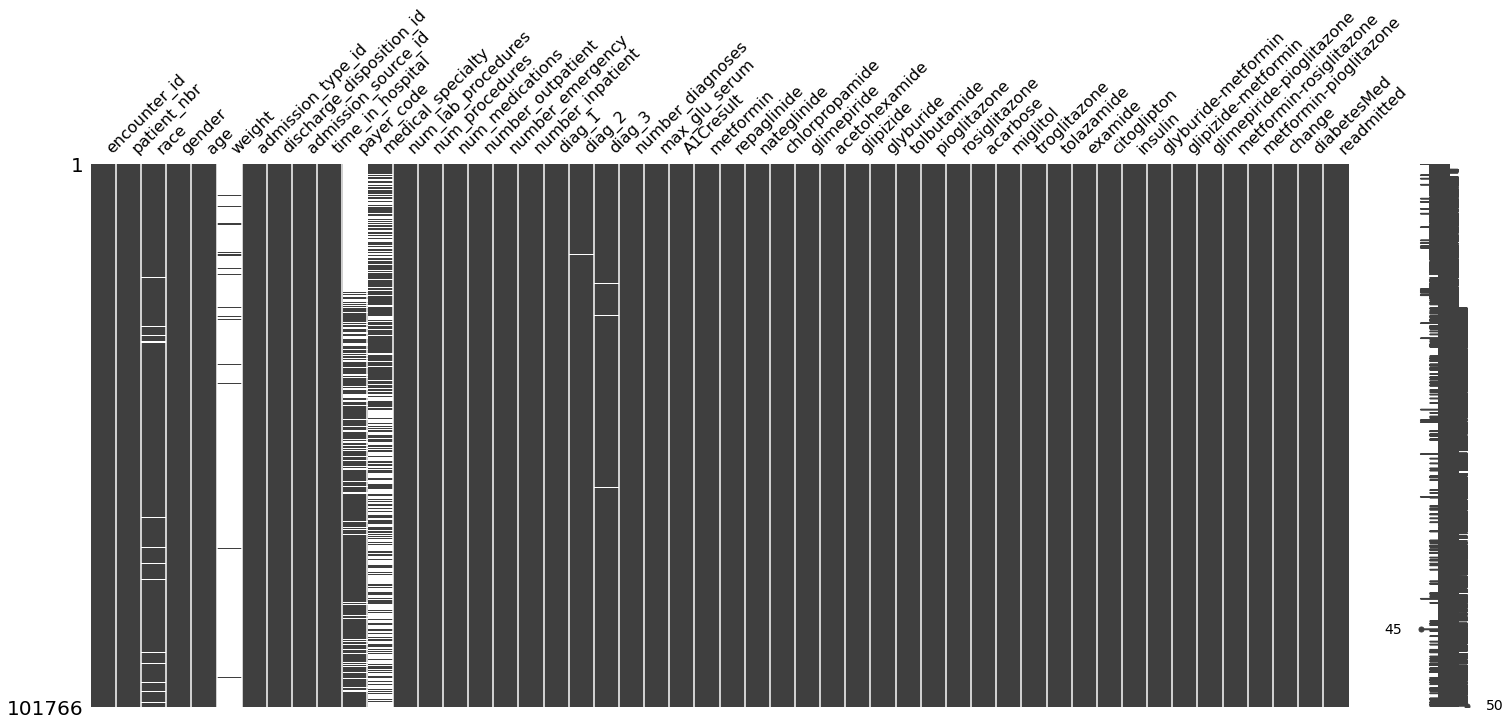

In [9]:
msno.matrix(data)
plt.show()

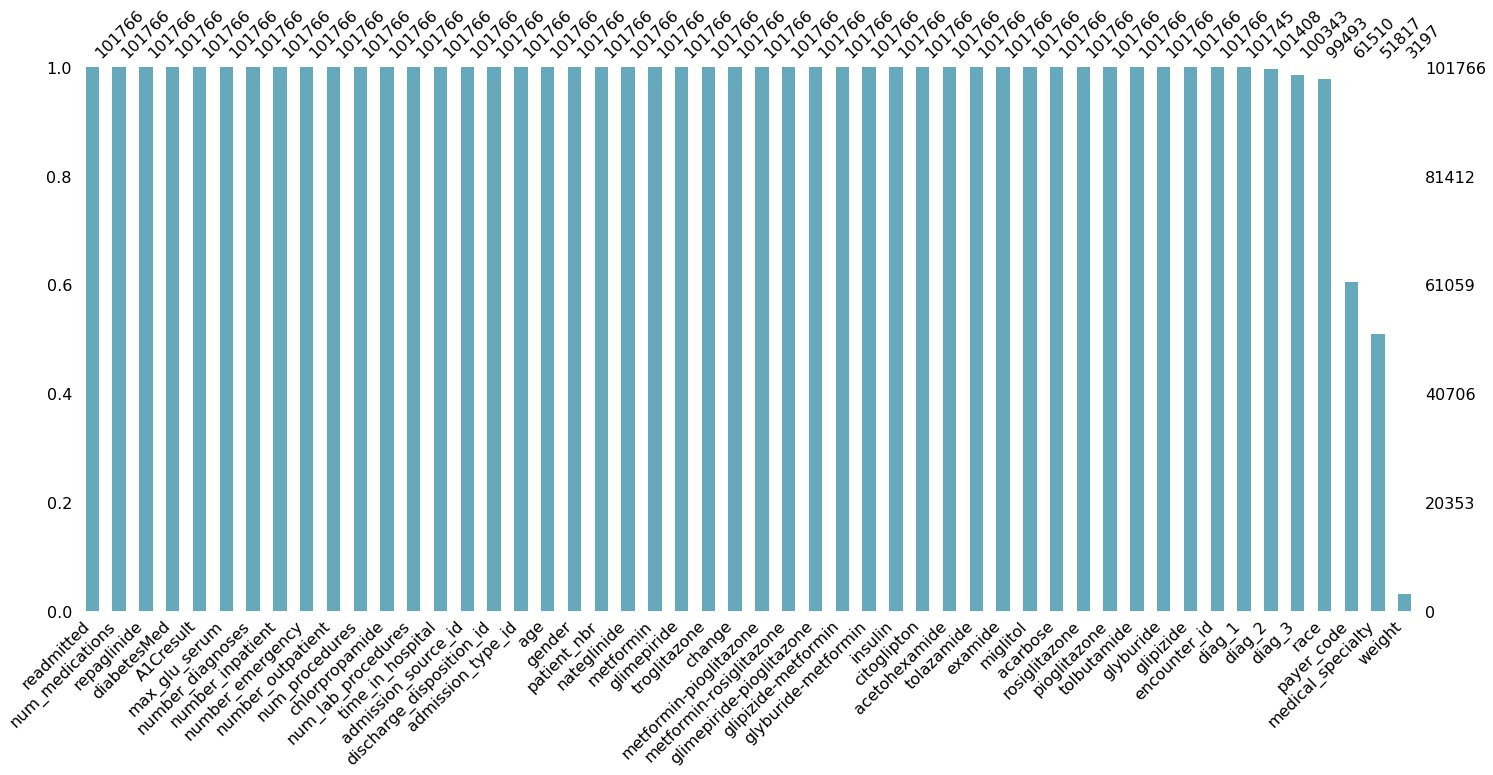

In [10]:
msno.bar(data,sort='descending',color='#66a9bc')
plt.show()

<strong>looking at the plots above</strong> we see that the missing values are in the columns: weight, medical_speciality, payer_code, race, and diag_1,2,3.

In [11]:
# This function helps giving more insights 
# about the nature of the values in the dataset like:
# the missing values, unique values, the percentage of values missing in each column
def Missing_Values(data):
    variable_name = []
    total_value = []
    total_missing_value = []
    missing_value_rate = []
    unique_value_list = []
    total_unique_value = []
    data_type = []
    
    for col in data.columns:
        variable_name.append(col)
        data_type.append(data[col].dtype)
        total_value.append(data[col].shape[0])
        total_missing_value.append(data[col].isnull().sum())
        missing_value_rate.append(round(data[col].isnull().sum()/data[col].shape[0],4))
        unique_value_list.append(data[col].unique())
        total_unique_value.append(len(data[col].unique()))
        
    missing_data=pd.DataFrame({"Variable":variable_name,\
                               "#_Total_Value":total_value,\
                               "#_Total_Missing_Value":total_missing_value,\
                               "%_Missing_Value_Rate":missing_value_rate,\
                               "Data_Type":data_type,"Unique_Value":unique_value_list,\
                               "Total_Unique_Value":total_unique_value
                              })
    
    missing_data = missing_data.set_index("Variable")
    return missing_data.sort_values("#_Total_Missing_Value",ascending=False)

In [12]:
data_info = Missing_Values(data)
data_info

,#_Total_Value,#_Total_Missing_Value,%_Missing_Value_Rate,Data_Type,Unique_Value,Total_Unique_Value
Variable,,,,,,
weight,101766,98569,0.9686,object,"[nan, [75-100), [50-75), [0-25), [100-125), [2...",10
medical_specialty,101766,49949,0.4908,object,"[Pediatrics-Endocrinology, nan, InternalMedici...",73
payer_code,101766,40256,0.3956,object,"[nan, MC, MD, HM, UN, BC, SP, CP, SI, DM, CM, ...",18
race,101766,2273,0.0223,object,"[Caucasian, AfricanAmerican, nan, Other, Asian...",6
diag_3,101766,1423,0.0140,object,"[nan, 255, V27, 403, 250, V45, 38, 486, 996, 1...",790
diag_2,101766,358,0.0035,object,"[nan, 250.01, 250, 250.43, 157, 411, 492, 427,...",749
diag_1,101766,21,0.0002,object,"[250.83, 276, 648, 8, 197, 414, 428, 398, 434,...",717
encounter_id,101766,0,0.0000,int64,"[2278392, 149190, 64410, 500364, 16680, 35754,...",101766
tolazamide,101766,0,0.0000,object,"[No, Steady, Up]",3


In [13]:
# Dropping the useless non-impactful columns
drop_list = ['examide' , 'citoglipton', 'weight','encounter_id','patient_nbr','payer_code','medical_specialty']  
data.drop(drop_list,axis=1, inplace=True)
data_info.drop(drop_list, axis=0,inplace=True)

**Splitting the numerical and non-numerical attributes for better preprocessing**

In [14]:
cols_num = ['time_in_hospital','num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient','number_diagnoses']
data[cols_num].isnull().sum()

time_in_hospital      0
num_lab_procedures    0
num_procedures        0
num_medications       0
number_outpatient     0
number_emergency      0
number_inpatient      0
number_diagnoses      0
dtype: int64

In [15]:
cols_cat = ['race', 'gender', 
       'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed']
data[cols_cat].isnull().sum()

race                        2273
gender                         0
max_glu_serum                  0
A1Cresult                      0
metformin                      0
repaglinide                    0
nateglinide                    0
chlorpropamide                 0
glimepiride                    0
acetohexamide                  0
glipizide                      0
glyburide                      0
tolbutamide                    0
pioglitazone                   0
rosiglitazone                  0
acarbose                       0
miglitol                       0
troglitazone                   0
tolazamide                     0
insulin                        0
glyburide-metformin            0
glipizide-metformin            0
glimepiride-pioglitazone       0
metformin-rosiglitazone        0
metformin-pioglitazone         0
change                         0
diabetesMed                    0
dtype: int64

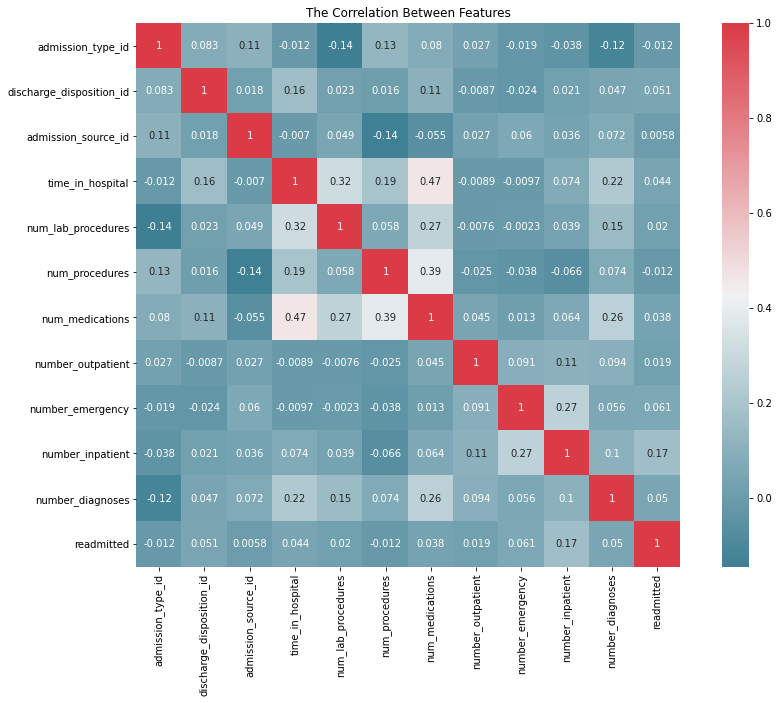

In [16]:
f, ax = plt.subplots(figsize=(15, 10))
corr = data.corr()
sns.heatmap(corr,mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, annot = True, ax=ax)
plt.title('The Correlation Between Features')
plt.show()

**After looking at the coorelation map, we notice that the coorelations between the feature and the target class are low.**

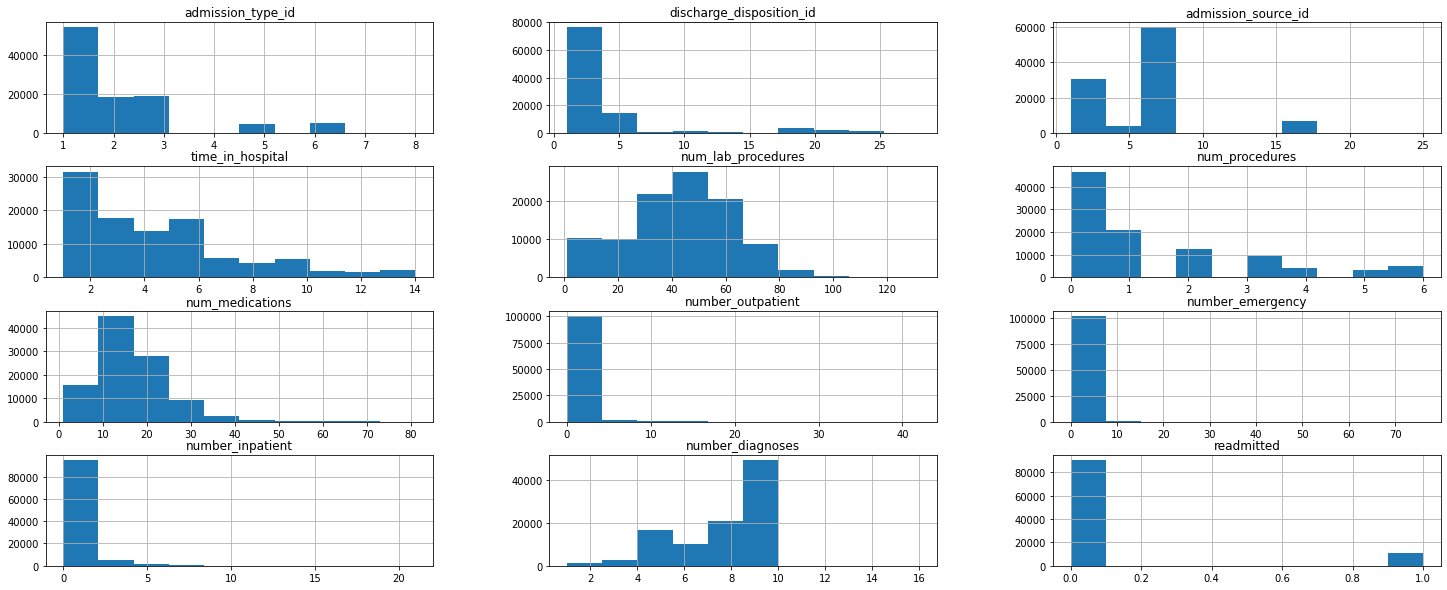

In [17]:
data.hist(figsize=(25, 10))
plt.show()

Looking at the barchart of some of the features of the dataset, we see that there is some outliers which is going to be dealt with using clustring techniques.

In [18]:
# updating the NULL value to be able to get rid of them
data.gender.replace('Unknown/Invalid', np.nan , inplace=True)
data.dropna(subset=['gender'], how='all', inplace = True)
data.gender.value_counts()

Female    54708
Male      47055
Name: gender, dtype: int64

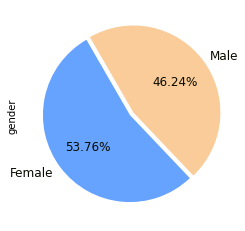

In [19]:
# visualising the distribution of the males vs femals in the dataset
labels=['Female','Male']
data.gender.value_counts().plot.pie(autopct="%1.2f%%", colors=['#66a3ff','#facc99'], 
                                        labels=labels, explode = (0, 0.05), startangle=120,
                                        textprops={'fontsize': 12, 'color':'#0a0a00'})
plt.show()

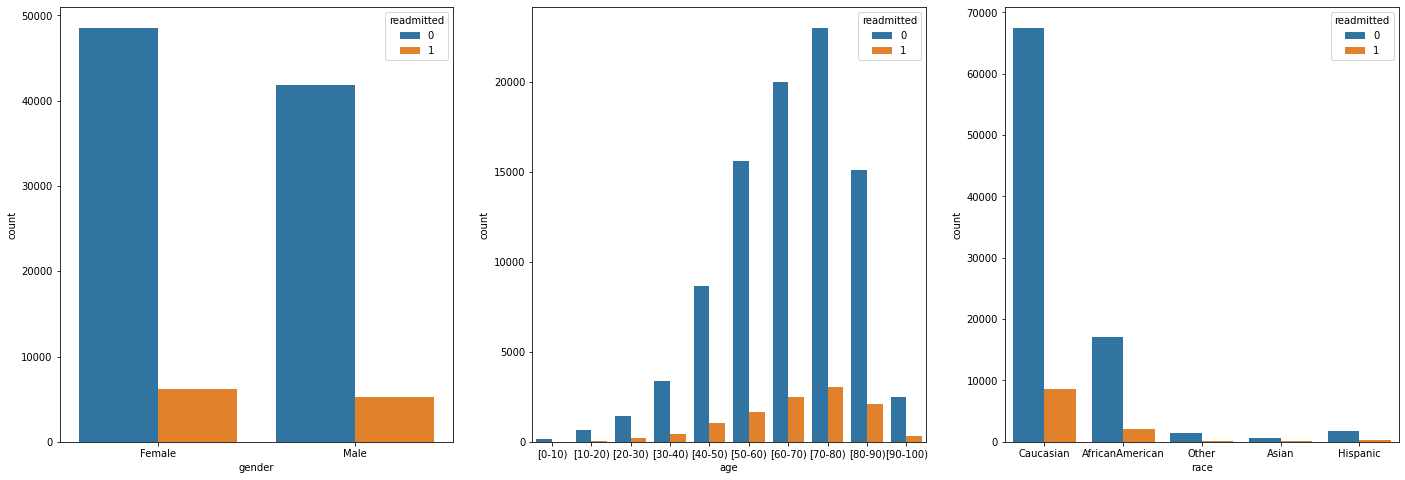

In [20]:
# looking at the impact of each of 'gender','age','race' on the target class
visual_list = ['gender','age','race']
fig, ax =plt.subplots(nrows=1,ncols=3,figsize=(24,8))
ax_col =0
for i in visual_list:
    sns.countplot(x=data[i], hue=data.readmitted, ax=ax[ax_col]);
    ax_col = ax_col+1

**Looking at the figures above we see that females that are between 80-90 years old and their race is caucasin are the most readmitted among all the types of people.**

In [21]:
data.groupby(by = "insulin").readmitted.mean()

insulin
Down      0.138975
No        0.100380
Steady    0.111284
Up        0.129905
Name: readmitted, dtype: float64

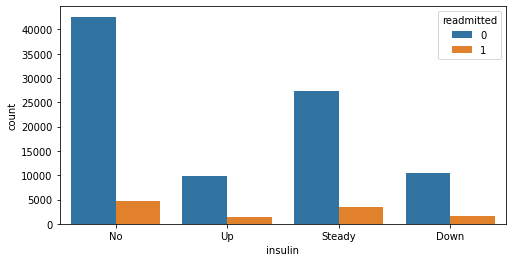

In [22]:
# Visualising the impact of insulin intake on the target class
fig =plt.subplots(figsize=(8,4))
sns.countplot(x="insulin", hue="readmitted", data=data, )
plt.show()

**The figure indicates that the people who does not take insulin are the most readmitted**

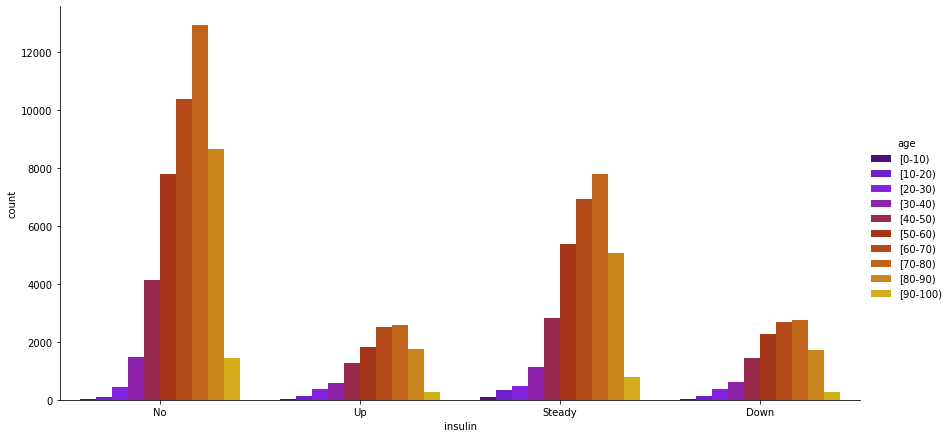

In [23]:
age_list = list(data.age.unique())
sns.catplot(x="insulin", hue="age", data=data, kind="count", height=6, aspect=2, palette="gnuplot");

**The figure indicates that the people who does not take insulin and their age is between 70-80 are the most readmitted, and people with age between 70-80 are the most readmitted in all types of insulin intake**

In [24]:
# checking for null values in the race feature
data["race"].fillna(data["race"].mode()[0], inplace = True)
data["race"].isnull().sum()

0

**Here we perform some function and technique to clean up the diagnosis columns 'diag_1','diag_2','diag_3' and make it more clear**

In [25]:
diag_list = ['diag_1','diag_2','diag_3']

for col in diag_list:
    data[col].fillna('NaN', inplace=True)

In [26]:
def transformFunc(value):
    value = re.sub("V[0-9]*", "0", value) # V 
    value = re.sub("E[0-9]*", "0", value) # E 
    value = re.sub('NaN', "-1", value) # Nan 
    return value

def transformCategory(value):
    if value>=390 and value<=459 or value==785:
        category = 'Circulatory'
    elif value>=460 and value<=519 or value==786:
        category = 'Respiratory'
    elif value>=520 and value<=579 or value==787:
        category = 'Digestive'
    elif value==250:
        category = 'Diabetes'
    elif value>=800 and value<=999:
        category = 'Injury'          
    elif value>=710 and value<=739:
        category = 'Musculoskeletal'   
    elif value>=580 and value<=629 or value==788:
        category = 'Genitourinary'
    elif value>=140 and value<=239 :
        category = 'Neoplasms'
    elif value==-1:
        category = 'NAN'
    else :
        category = 'Other'

    return category

In [27]:
for col in diag_list:
    data[col] = data[col].apply(transformFunc)
    data[col] = data[col].astype(float)

In [28]:
for col in diag_list:
    data[col] = data[col].apply(transformCategory)

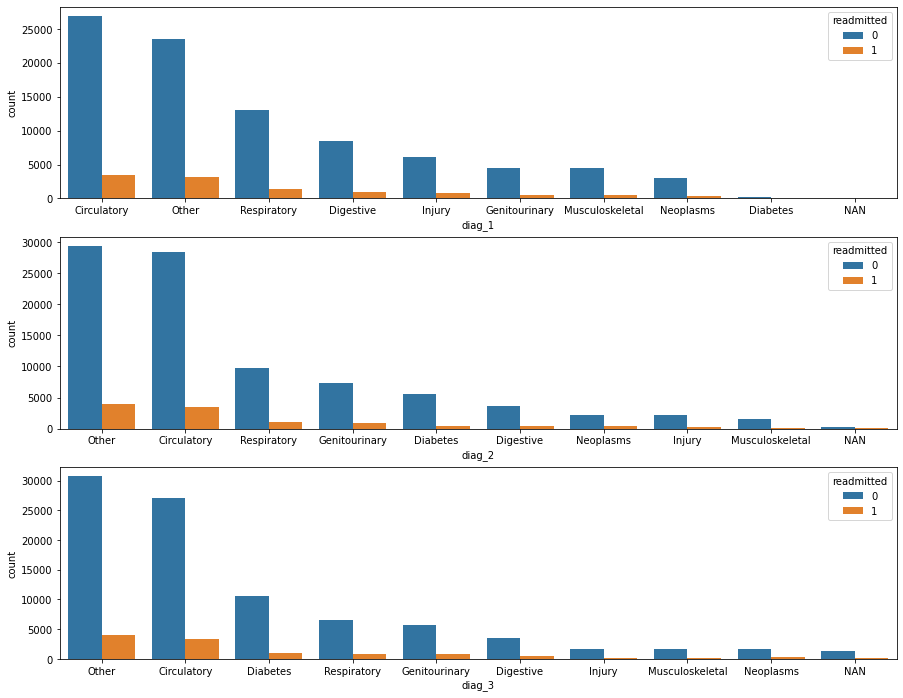

In [29]:
fig, ax =plt.subplots(nrows=3,ncols=1,figsize=(15,12))
row_ax =0
for i in diag_list:
    sns.countplot(x= data[i], hue=data.readmitted, ax=ax[row_ax], order = data[i].value_counts().index);
    row_ax = row_ax+1

**After Cleaning the diagnosis columns and plotting the distribution of it, we see that the people diagnosed with Circulatory are the most readmitted**

### Data Cleaning and Encoding

In [30]:
# Custom encoding for the 21 Drug Features
drugs = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
        'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin', 'tolazamide', 'metformin-pioglitazone',
        'metformin-rosiglitazone', 'glimepiride-pioglitazone', 'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide']

for col in drugs:
    data[col] = data[col].replace(['No','Steady','Up','Down'],[0,1,1,1])
    data[col] = data[col].astype(int)

In [31]:
# A1Cresult and max_glu_serum attributes cleanning
data['A1Cresult'] = data['A1Cresult'].replace(['>7','>8','Norm','None'],[1,1,0,-99])
data['max_glu_serum'] = data['max_glu_serum'].replace(['>200','>300','Norm','None'],[1,1,0,-99])

In [32]:
# One hot Encoding Race and Id's 
one_hot_data = pd.get_dummies(data, columns=['race'], prefix=["enc"])

columns_ids = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']

one_hot_data[columns_ids] = one_hot_data[columns_ids].astype('str')
one_hot_data = pd.get_dummies(one_hot_data, columns=columns_ids)

In [33]:
# Encoding the Rest of the categorical attributes
binary = ['change', 'diabetesMed', 'gender']
df = one_hot_data.copy()

for col in diag_list:
    df[col] = LabelEncoder().fit_transform(df[col])

for col in binary:
    df[col] = LabelEncoder().fit_transform(df[col])
    
df['age'] = OrdinalEncoder().fit_transform(df['age'].values.reshape(-1, 1))

X = df.drop(columns="readmitted", axis=1)
Y = df.readmitted

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 42)

**After Encoding all the attributes, now the dataset is ready for the preprocessing phase**

## Data Preprocessing

### Outlier Removal Using Clustring
<strong>DBSCAN technique </strong> is used to deal with outliers**

In [34]:
model = DBSCAN(eps = 3,metric = 'manhattan',n_jobs=-1).fit(X)
outliers = df[model.labels_ != -1]
cluster = df[model.labels_ == -1]
print("The number of outliers that has been removed ", outliers.shape[0],"which is: ", "{:.2f}".format(outliers.shape[0]/ X.shape[0] *100), "%")
print("The number of data without outliers ",cluster.shape[0],"which is: ", "{:.2f}".format(cluster.shape[0]/ X.shape[0] *100),"%")

The number of outliers that has been removed  35 which is:  0.03 %
The number of data without outliers  101728 which is:  99.97 %


In [35]:
# Creating the new Dataset after clustring
X = cluster.drop(columns="readmitted", axis=1)
Y = cluster.readmitted

In [36]:
cluster['readmitted'].value_counts()

0    90372
1    11356
Name: readmitted, dtype: int64

### Undersampling (NearMiss) and Downsampling

In [37]:
# Using NearMiss method to undersample the data
sampler = NearMiss(version=1,sampling_strategy={0: 20000, 1: 11356})
x_under, y_under = sampler.fit_sample(X, Y)

# Creating the new train and validation after the upsampling
Xu_train, Xu_val, yu_train, yu_val = train_test_split(x_under, y_under, test_size = 0.20, random_state = 42)

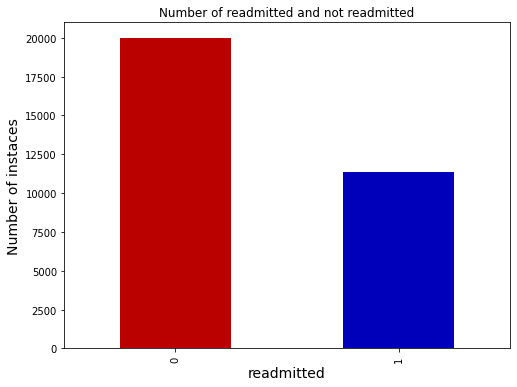

In [38]:
ax=y_under.value_counts().plot(kind='bar',color = ['#BB0000', '#0000BB'],
                                          title='Number of readmitted and not readmitted',figsize=(8, 6))
ax.set_xlabel("readmitted",fontsize=14)
ax.set_ylabel("Number of instaces",fontsize=14)
plt.show()

**After performing the undersampling we see that the data is more balanced now**

In [39]:
X = pd.concat([X_train, y_train], axis=1)

not_readmitted = X[X.readmitted==0]
readmitted = X[X.readmitted==1]

not_readmitted_sampled = resample(not_readmitted,
                                replace = False, 
                                n_samples = len(readmitted),
                                random_state = 42)

downsampled = pd.concat([not_readmitted_sampled, readmitted])

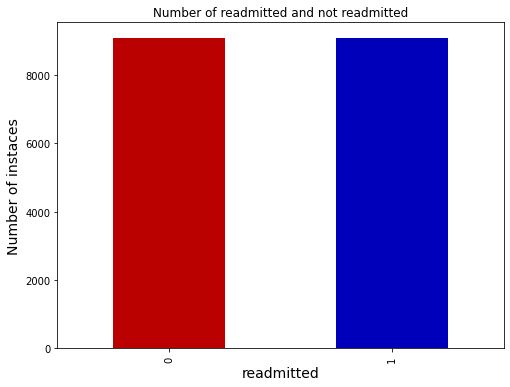

In [40]:
ax=downsampled['readmitted'].value_counts().plot(kind='bar',color = ['#BB0000', '#0000BB'],
                                          title='Number of readmitted and not readmitted',figsize=(8, 6))
ax.set_xlabel("readmitted",fontsize=14)
ax.set_ylabel("Number of instaces",fontsize=14)
plt.show()

**After performing the downampling we see that the data is more balanced but we lost so many instances.**

In [41]:
# creating the train and validation after the downsampling
y_down = downsampled.readmitted
X_down = downsampled.drop('readmitted', axis=1)
Xd_train, Xd_val, yd_train, yd_val = train_test_split(X_down, y_down, test_size = 0.2, random_state = 42)

In [42]:
# Standard Scaler to finish the preprocessing phase
sc1= StandardScaler()
Xu_train = sc1.fit_transform(Xu_train)
Xu_val = sc1.transform(Xu_val)

Xd_train = sc1.fit_transform(Xd_train)
Xd_val = sc1.transform(Xd_val)

## Applying Machine Learning Models
**In this section, different machine learning models were implemented to see which is the best model.**
<strong>Below are the models implemented:</strong>
<ul>
    <li>Logistic Regression</li>
    <li>Support Vector Machine</li>
    <li>Random Forest</li>
    <li>Ensmble Model 1: (SVM, Logistic Regression)</li>
    <li>Ensmble Model 2: (SVM, Random Forest)</li>
    <li>Ensmble Model 3: (SVM, Logistic Regression, Logistic Regression)</li>
</ul>

In [43]:
# This function outputs all the metrics needed to evaluate the models.
def print_report(x_val, y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_pred, y_actual)
    accuracy = accuracy_score((y_pred > thresh), y_actual)
    recall = recall_score((y_pred > thresh), y_actual)
    precision = precision_score((y_pred > thresh),y_actual)
    fscore = f1_score((y_pred > thresh), y_actual)
    
    print('AUC: %.3f'%auc)
    print('Accuracy: %.3f'%accuracy)
    print('Recall: %.3f'%recall)
    print('Precision: %.3f'%precision)
    print('F-Score: %.3f'%fscore)
    print(' ')
        
    return auc
thresh = 0.5

**Models Implemented**

In [44]:
lr=LogisticRegression(random_state = 42)
svc = SVC(probability=True)
rf = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=100, max_depth=3)
ensemble1 = VotingClassifier(estimators=[('svc',svc),('lr',lr)], voting ='soft', n_jobs=-1)
ensemble2 = VotingClassifier(estimators=[('svc',svc),('rf',rf)], voting ='soft', n_jobs=-1)
ensemble3 = VotingClassifier(estimators=[('svc',svc),('lr',lr),('rf',rf)], voting ='soft', n_jobs=-1)

### Implementing the models on the dataset created using the undersampling technique

In [45]:
lrus = lr.fit(Xu_train, yu_train)
lrus_preds = lrus.predict(Xu_val)

SVCus = svc.fit(Xu_train, yu_train)
SVCus_preds = SVCus.predict(Xu_val)

rfus = rf.fit(Xu_train, yu_train)
rfus_preds = rfus.predict(Xu_val)

ens1Us = ensemble1.fit(Xu_train, yu_train)
ens1Us_preds = ens1Us.predict(Xu_val)

ens2Us = ensemble2.fit(Xu_train, yu_train)
ens2Us_preds = ens2Us.predict(Xu_val)

ens3Us = ensemble3.fit(Xu_train, yu_train)
ens3Us_preds = ens3Us.predict(Xu_val)

**Evaluation of the models**

In [46]:
string='\033[1m'+'Logistic Regression Undersample'+'\033[0m'
print(string.center(60))
print('\033[1m'+'Validation:'+'\033[0m')
lrus_auc = print_report(Xu_val, yu_val, lrus_preds, thresh)

string='\033[1m'+'Support Vector Machine Undersample'+"\033[0m"
print(string.center(60))
print('\033[1m'+'Validation:'+'\033[0m')
SVCus_auc = print_report(Xu_val, yu_val, SVCus_preds, thresh)

string='\033[1m'+'Random Forest Undersample'+"\033[0m"
print(string.center(60))
print('\033[1m'+'Validation:'+'\033[0m')
rfus_auc = print_report(Xu_val, yu_val, rfus_preds, thresh)

string='\033[1m'+'Ensmble Model1 Undersample'+"\033[0m"
print(string.center(60))
print('\033[1m'+'Validation:'+'\033[0m')
ens1us_auc = print_report(Xu_val, yu_val, ens1Us_preds, thresh)

string='\033[1m'+'Ensmble Model2 Undersample'+"\033[0m"
print(string.center(60))
print('\033[1m'+'Validation:'+'\033[0m')
en2us_auc = print_report(Xu_val, yu_val, ens2Us_preds, thresh)

string='\033[1m'+'Ensmble Model3 Undersample'+"\033[0m"
print(string.center(60))
print('\033[1m'+'Validation:'+'\033[0m')
ens3us_auc = print_report(Xu_val, yu_val, ens3Us_preds, thresh)

          Logistic Regression Undersample           
Validation:
AUC: 0.779
Accuracy: 0.780
Recall: 0.776
Precision: 0.553
F-Score: 0.645
 
         Support Vector Machine Undersample         
Validation:
AUC: 0.805
Accuracy: 0.789
Recall: 0.834
Precision: 0.520
F-Score: 0.641
 
             Random Forest Undersample              
Validation:
AUC: 0.819
Accuracy: 0.711
Recall: 0.947
Precision: 0.214
F-Score: 0.349
 
             Ensmble Model1 Undersample             
Validation:
AUC: 0.798
Accuracy: 0.794
Recall: 0.807
Precision: 0.565
F-Score: 0.664
 
             Ensmble Model2 Undersample             
Validation:
AUC: 0.813
Accuracy: 0.790
Recall: 0.852
Precision: 0.509
F-Score: 0.637
 
             Ensmble Model3 Undersample             
Validation:
AUC: 0.808
Accuracy: 0.791
Recall: 0.839
Precision: 0.524
F-Score: 0.645
 


**After looking at the results of the model, Random Forest Scored the best AUC which is equal = 0.812, and Ensmble model 1 scored the best Accuracy score which is equal = 79.4%.**

 Confusion Matrices for Models Using Undersampling  


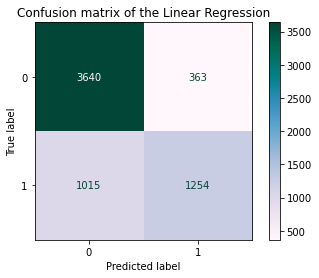

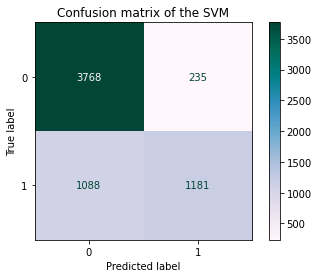

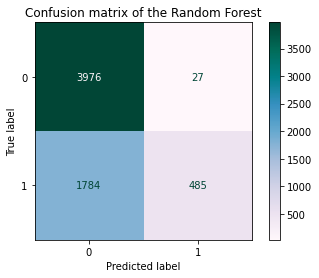

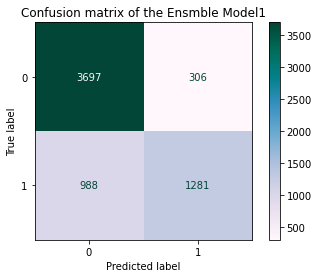

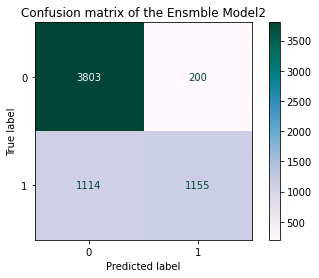

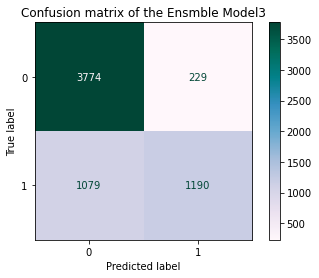

In [47]:
# Plotting the confusion matrices of the models
string='\033[1m'+'Confusion Matrices for Models Using Undersampling'+"\033[0m"
print(string.center(60))

plot_confusion_matrix(lrus, Xu_val, yu_val, cmap='PuBuGn')
plt.title('Confusion matrix of the Linear Regression')

plot_confusion_matrix(SVCus, Xu_val, yu_val, cmap='PuBuGn')
plt.title('Confusion matrix of the SVM')

plot_confusion_matrix(rfus, Xu_val, yu_val, cmap='PuBuGn')
plt.title('Confusion matrix of the Random Forest')
# ---------------
plot_confusion_matrix(ens1Us, Xu_val, yu_val, cmap='PuBuGn')
plt.title('Confusion matrix of the Ensmble Model1')

plot_confusion_matrix(ens2Us, Xu_val, yu_val, cmap='PuBuGn')
plt.title('Confusion matrix of the Ensmble Model2')

plot_confusion_matrix(ens3Us, Xu_val, yu_val, cmap='PuBuGn')
plt.title('Confusion matrix of the Ensmble Model3')
plt.show()

### Implementing the models on the dataset created using the downsampling technique

In [48]:
lrds = lr.fit(Xd_train, yd_train)
lrds_preds = lrds.predict(Xd_val)

SVCds = svc.fit(Xd_train, yd_train)
SVCds_preds = SVCds.predict(Xd_val)

rfds = rf.fit(Xd_train, yd_train)
rfds_preds = rfds.predict(Xd_val)

ens1Ds = ensemble1.fit(Xd_train, yd_train)
ens1Ds_preds = ens1Ds.predict(Xd_val)

ens2Ds = ensemble1.fit(Xd_train, yd_train)
ens2Ds_preds = ens2Ds.predict(Xd_val)

ens3Ds = ensemble1.fit(Xd_train, yd_train)
ens3Ds_preds = ens3Ds.predict(Xd_val)

**Evaluation of the models**

In [49]:
string='\033[1m'+'Logistic Regression Downsample'+'\033[0m'
print(string.center(60))
print('\033[1m'+'Validation:'+'\033[0m')
lrds_auc = print_report(Xd_val, yd_val, lrds_preds, thresh)

string='\033[1m'+'Support Vector Machine Downsample'+"\033[0m"
print(string.center(60))
print('\033[1m'+'Validation:'+'\033[0m')
SVCds_auc = print_report(Xd_val, yd_val, SVCds_preds, thresh)

string='\033[1m'+'Random Forest Downsample'+"\033[0m"
print(string.center(60))
print('\033[1m'+'Validation:'+'\033[0m')
rfds_auc= print_report(Xd_val, yd_val, rfds_preds, thresh)


string='\033[1m'+'Ensmble Model1 Undersample'+"\033[0m"
print(string.center(60))
print('\033[1m'+'Validation:'+'\033[0m')
ens1ds_auc = print_report(Xd_val, yd_val, ens1Ds_preds, thresh)

string='\033[1m'+'Ensmble Model2 Undersample'+"\033[0m"
print(string.center(60))
print('\033[1m'+'Validation:'+'\033[0m')
ens2ds_auc = print_report(Xd_val, yd_val, ens2Ds_preds, thresh)

string='\033[1m'+'Ensmble Model3 Undersample'+"\033[0m"
print(string.center(60))
print('\033[1m'+'Validation:'+'\033[0m')
ens3ds_auc = print_report(Xd_val, yd_val, ens3Ds_preds, thresh)

           Logistic Regression Downsample           
Validation:
AUC: 0.617
Accuracy: 0.616
Recall: 0.627
Precision: 0.551
F-Score: 0.587
 
         Support Vector Machine Downsample          
Validation:
AUC: 0.625
Accuracy: 0.624
Recall: 0.636
Precision: 0.563
F-Score: 0.597
 
              Random Forest Downsample              
Validation:
AUC: 0.614
Accuracy: 0.613
Recall: 0.603
Precision: 0.639
F-Score: 0.621
 
             Ensmble Model1 Undersample             
Validation:
AUC: 0.626
Accuracy: 0.625
Recall: 0.631
Precision: 0.584
F-Score: 0.607
 
             Ensmble Model2 Undersample             
Validation:
AUC: 0.625
Accuracy: 0.625
Recall: 0.631
Precision: 0.583
F-Score: 0.606
 
             Ensmble Model3 Undersample             
Validation:
AUC: 0.626
Accuracy: 0.625
Recall: 0.631
Precision: 0.583
F-Score: 0.606
 


**After looking at the results of the model, All ensmble models Scored the same Auccracy score which is considered the best and it is equal = 62.5%, and Ensmble model 1, 3 scored the best AUC which is equal = 0.626.**

  Confusion Matrices for Models Using Downsampling  


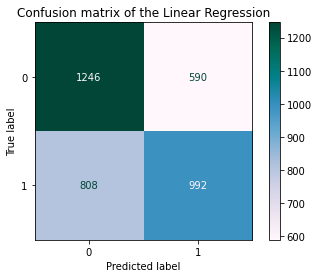

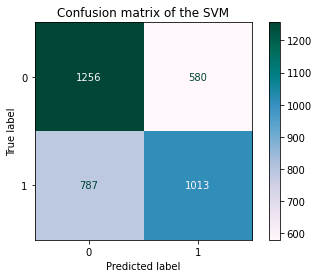

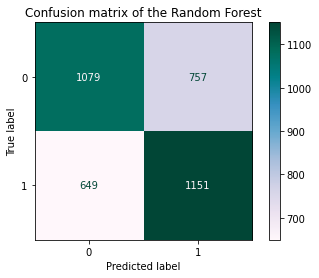

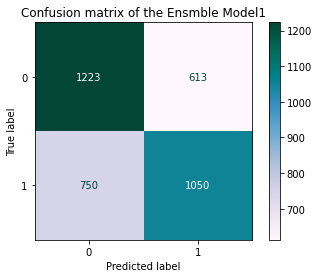

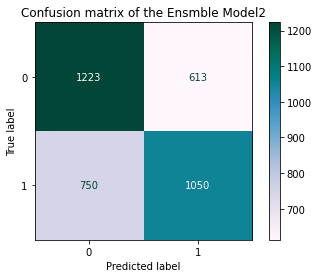

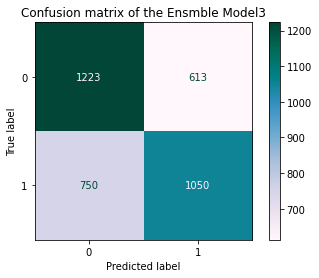

In [50]:
# Plotting the confusion matrices of the models
string='\033[1m'+'Confusion Matrices for Models Using Downsampling'+"\033[0m"
print(string.center(60))

plot_confusion_matrix(lrds, Xd_val, yd_val, cmap='PuBuGn')
plt.title('Confusion matrix of the Linear Regression')

plot_confusion_matrix(SVCds, Xd_val, yd_val, cmap='PuBuGn')
plt.title('Confusion matrix of the SVM')

plot_confusion_matrix(rfds, Xd_val, yd_val, cmap='PuBuGn')
plt.title('Confusion matrix of the Random Forest')

plot_confusion_matrix(ens1Ds, Xd_val, yd_val, cmap='PuBuGn')
plt.title('Confusion matrix of the Ensmble Model1')

plot_confusion_matrix(ens2Ds, Xd_val, yd_val, cmap='PuBuGn')
plt.title('Confusion matrix of the Ensmble Model2')

plot_confusion_matrix(ens3Ds, Xd_val, yd_val, cmap='PuBuGn')
plt.title('Confusion matrix of the Ensmble Model3')
plt.show()

## ROC Curves

**In this section we plot the ROC Curves to give us better intuition about the models.**

### ROC of models implemented on the upsampled dataset 

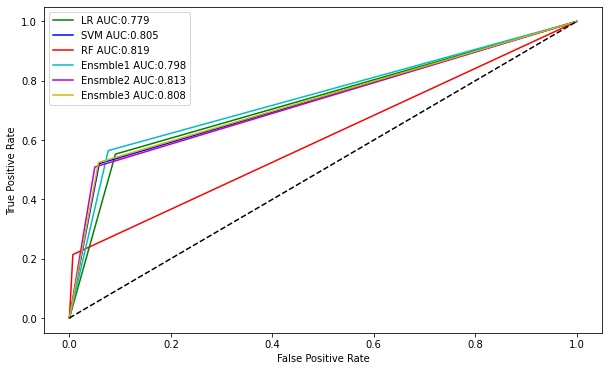

In [51]:
fig = plt.figure(figsize=(10,6))
fpr_lrus, tpr_lrus, thresholds_lrus = roc_curve(yu_val, lrus_preds)
plt.plot(fpr_lrus, tpr_lrus, 'g-',label ='LR AUC:%.3f'%lrus_auc)

fpr_SVCus, tpr_SVCus, thresholds_SVCus = roc_curve(yu_val, SVCus_preds)
plt.plot(fpr_SVCus, tpr_SVCus, 'b-',label ='SVM AUC:%.3f'%SVCus_auc)

fpr_rfus, tpr_rfus, thresholds_rfus = roc_curve(yu_val, rfus_preds)
plt.plot(fpr_rfus, tpr_rfus, 'r-',label ='RF AUC:%.3f'%rfus_auc)

fpr_ens1Us, tpr_ens1Us, thresholds_ens1Us = roc_curve(yu_val, ens1Us_preds)
plt.plot(fpr_ens1Us, tpr_ens1Us, 'c-',label ='Ensmble1 AUC:%.3f'%ens1us_auc)

fpr_ens2Us, tpr_ens2Us, thresholds_ens2Us = roc_curve(yu_val, ens2Us_preds)
plt.plot(fpr_ens2Us, tpr_ens2Us, 'm-',label ='Ensmble2 AUC:%.3f'%en2us_auc)

fpr_ens3Us, tpr_ens3Us, thresholds_ens3Us = roc_curve(yu_val, ens3Us_preds)
plt.plot(fpr_ens3Us, tpr_ens3Us, 'y-',label ='Ensmble3 AUC:%.3f'%ens3us_auc)

plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### ROC of models implemented on the downsampled dataset 

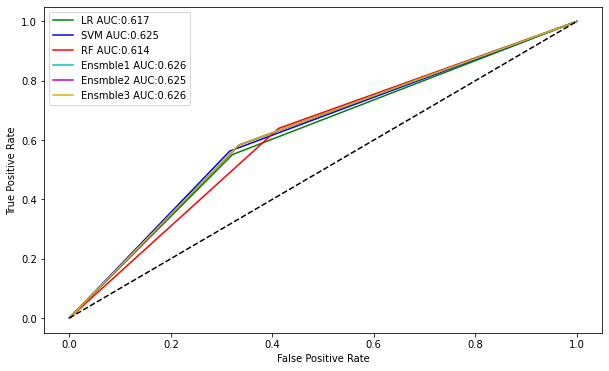

In [52]:
fig = plt.figure(figsize=(10,6))
fpr_lrds, tpr_lrds, thresholds_lrds = roc_curve(yd_val, lrds_preds)
plt.plot(fpr_lrds, tpr_lrds, 'g-',label ='LR AUC:%.3f'%lrds_auc)

fpr_SVCds, tpr_SVCds, thresholds_SVCds = roc_curve(yd_val, SVCds_preds)
plt.plot(fpr_SVCds, tpr_SVCds, 'b-',label ='SVM AUC:%.3f'%SVCds_auc)

fpr_rfds, tpr_rfds, thresholds_rfds = roc_curve(yd_val, rfds_preds)
plt.plot(fpr_rfds, tpr_rfds, 'r-',label ='RF AUC:%.3f'%rfds_auc)

fpr_ens1Ds, tpr_ens1Ds, thresholds_ens1Ds = roc_curve(yd_val, ens1Ds_preds)
plt.plot(fpr_ens1Ds, tpr_ens1Ds, 'c-',label ='Ensmble1 AUC:%.3f'%ens1ds_auc)

fpr_ens2Ds, tpr_ens2Ds, thresholds_ens2Ds = roc_curve(yd_val, ens2Ds_preds)
plt.plot(fpr_ens2Ds, tpr_ens2Ds, 'm-',label ='Ensmble2 AUC:%.3f'%ens2ds_auc)

fpr_ens3Ds, tpr_ens3Ds, thresholds_ens3Ds = roc_curve(yd_val, ens3Ds_preds)
plt.plot(fpr_ens3Ds, tpr_ens3Ds, 'y-',label ='Ensmble3 AUC:%.3f'%ens3ds_auc)

plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## Conclusion

Through this project, we created a binary classifier to predict the probability that a patient with diabetes would be readmitted to the hospital within 30 days. We compared between the datasets created with different resampling techniques (upsampling and downsampling) using 6 different models which are: logistic regresstion, support vector machine, random forest, Ensmble Model 1: (SVM, Logistic Regression), Ensmble Model 2: (SVM, Random Forest), Ensmble Model 3: (SVM, Logistic Regression, Logistic Regression). The results based on the confusion matrices and different evaulation metrics showed that the dataset created using upsampling technique produced more accurate model implementation than the dataset created using downsampling technique. The overall best model which scored the highest AUC = 0.819 was the Random forest implemented on the upsampled dataset.